### **Modelling Assignment 3 (Group Component)**
Group 17: Raihan Arvi, Parsa Nayyara, Malcolm Maxwell

#### **Prompt**
*Construct a linear regression model to predict the duration of sleep from the other columns in sleep.csv. In your model construction, you may find it necessary to “transform” some of the variables. Determine the best linear regression model to predict the Sleep Duration. If you choose a model with transformed variables, it is expected that you will compare the transformed model results with the results from a standard multiple linear regression (i.e., without transformed data). Be sure to clearly state which linear regression your group deems to be the ‘best’ and explain why you have chosen this model. Be sure to mention how duration may be dependent on the mattress and pillow used.*

*Note: Since some of the data is ranked on a scale of 1 to 10, we will see “columns” of data points when looking at some of the diagnostic plots at the integer or half-integer values (i.e., the points on the rank scale). In these cases, when we are looking for “random scatter”, we look vertically in the column to see if the points have any pattern and to see if the points are “equally” distributed over the horizontal y = 0 line (if applicable). If we do not see a equal distribution in the columns of the plots, then we may be concerned that one (or more) of the linear regression assumptions are violated. Be sure to mention how diagnostic plots resulting from covariates that are on Likert scales can be challenging to interpret. Do NOT split the data into a training and testing set: i.e., use all of the data to construct the linear regression model.*


#### **1. Problem Statement**

To construct a linear regression model to relate sleep duration from sleep quality, physical activity during the day, and stress level; and compare transformed model vs standard multiple linear regression.

#### **2. Variables and Parameters** <br>

**Variables**

| Type                  | Description               | Dimension | Unit  |
|-----------------------|---------------------------|-----------|-------|
| Independent variable  | Quality of Sleep                  | 1         | 1  |
| Independent variable  | Physical Activity during day      | 1         | minutes/day  |
| Independent variable  | Stress Level                      | 1         | 1  |
| Dependent variable  | Sleep Duration                      | T         | hours  |

</br>

**Parameters**
| Type | Description | Symbol | Dimension | Value    | Unit |
|------|-------------|--------|-----------|----------|------|
| Parameter | Constant Coefficient | $\beta_0$ | 1 |  | hours 
| Parameter | Change in sleep duration per one unit change in physical activity | $\beta_1$ | 1 |  | hours 
| Parameter | Change in sleep duration per one unit change in stress level | $\beta_2$ | 1 |  | 60 $\cdot$ day 
| Parameter | Change in sleep duration per one unit change in sleep quality | $\beta_3$ | 1 |  | hours 
| Parameter | Residual | $\epsilon$ | 1 |  | hours

#### **3. Assumptions and Constraints**

*   Average value of the error is zero
*   Variance is constant
*   Errors are normally distributed
*   Errors are independent
*   Data collected are measured reliably, no systematic error
*   There are no other factors that impact the target variable other the the ones listed

#### **4. Build Solution**

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
df = pd.read_csv("Sleep.csv")
df.head()

,Duration,Quality,Physical_Activity,Stress
0,6.1,6,42,6
1,6.2,6,60,8
2,6.2,6,60,8
3,5.9,4,30,8
4,5.9,4,30,8


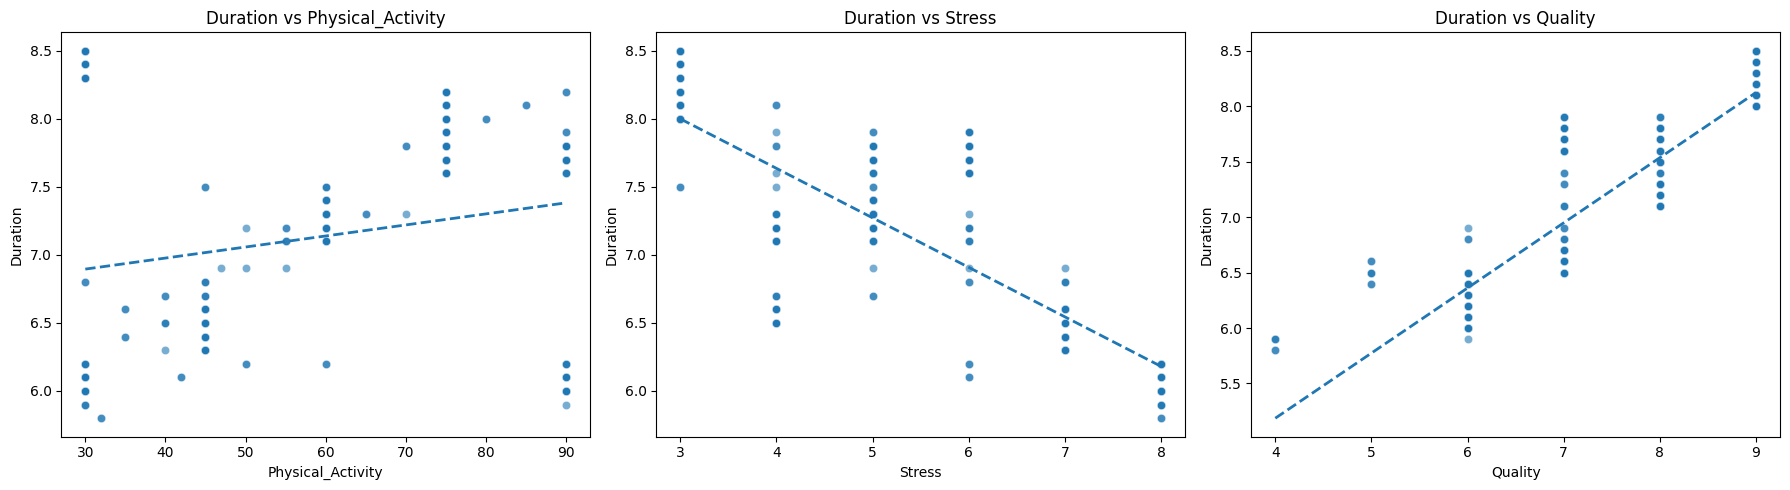

In [4]:
# Duration vs. each predictor
response = "Duration"
predictors = ["Physical_Activity", "Stress", "Quality"]

fig, axes = plt.subplots(1, len(predictors), figsize=(18,5))
for ax, pred in zip(axes, predictors):
    sns.scatterplot(x=df[pred], y=df[response], ax=ax, alpha=0.6)
    sns.regplot(x=df[pred], y=df[response], ax=ax,
                scatter=False, ci=None, line_kws={"lw":2, "ls":"--"})
    ax.set_xlabel(pred)
    ax.set_ylabel(response)
    ax.set_title(f"{response} vs {pred}")
plt.tight_layout()
plt.show()

X = sm.add_constant(df[['Physical_Activity','Stress','Quality']])
Y = df['Duration']
model = sm.OLS(Y, X).fit()
print(model.summary())

#### Baseline Model

In [5]:
# baseline model
X_baseline = sm.add_constant(df[["Physical_Activity","Stress","Quality"]])
Y_baseline = df["Duration"]

model_baseline = sm.OLS(Y_baseline, X_baseline).fit()
print("Baseline Model:")
print(model_baseline.summary())
print(f"Adjusted R^2 (baseline): {model_baseline.rsquared_adj:.5f}")

Baseline Model:
                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     450.5
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          4.13e-123
Time:                        21:11:50   Log-Likelihood:                -157.20
No. Observations:                 374   AIC:                             322.4
Df Residuals:                     370   BIC:                             338.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 

In [6]:
# run this cell (assumes df is loaded and pandas/numpy/statsmodels imported)
import numpy as np
import pandas as pd
import statsmodels.api as sm

transform_list = [
    # predictor transforms (replace Stress or Quality in X)
    ("Stress_sqrt",      "predictor", "Stress", lambda s: np.sqrt(s)),
    ("Stress_sq",        "predictor", "Stress", lambda s: s**2),
    ("Quality_log",      "predictor", "Quality", lambda s: np.log(s)),
    ("Quality_sq",       "predictor", "Quality", lambda s: s**2),
    # response transforms (replace Duration with transformed response Y)
    ("Duration_log",     "response",  "Duration", lambda s: np.log(s)),
    ("Duration_sqrt",    "response",  "Duration", lambda s: np.sqrt(s)),
]

results = []
for name, kind, col, func in transform_list:

    temp = df[['Duration','Physical_Activity','Stress','Quality']].copy()

    # apply transformation.
    if func is np.log:
        temp[col] = temp[col].where(temp[col] > 0, np.nan).map(lambda v: np.log(v) if pd.notna(v) else np.nan)
    else:
        # for sqrt of negative numbers numpy gives nan; keep that behavior
        temp[col] = func(temp[col].astype(float))
    # drop rows with NA in any of the model columns
    temp = temp.dropna(subset=['Duration','Physical_Activity','Stress','Quality'])

    # Build X and Y using the exact requested structure
    X_t = sm.add_constant(temp[['Physical_Activity','Stress','Quality']])
    if kind == "response":
        Y_t = temp['Duration'] if col != 'Duration' else temp['Duration']  # placeholder, but we set below
    # set Y_t properly when response transform
    if kind == "response":
        Y_t = temp[col]   # transformed Duration
    else:
        Y_t = temp['Duration']  # original response

    # fit and record adj. R^2
    m = sm.OLS(Y_t, X_t).fit()
    results.append((name, len(temp), m.rsquared_adj))

# summary table sorted by adj R2
res_df = pd.DataFrame(results, columns=['transformation','n_obs','adj_R2']).sort_values('adj_R2', ascending=False)
print("\n\n=== Summary (ranked by adj. R^2) ===")
display(res_df.reset_index(drop=True))



=== Summary (ranked by adj. R^2) ===


,transformation,n_obs,adj_R2
0,Quality_sq,374,0.795499
1,Duration_log,374,0.789244
2,Duration_sqrt,374,0.786617
3,Stress_sq,374,0.786230
4,Stress_sqrt,374,0.782382
5,Quality_log,374,0.761036


In [7]:
# prepare a working copy and create transforms
temp = df[['Duration','Physical_Activity','Stress','Quality']].copy()
temp['Quality_sq'] = temp['Quality'].astype(float) ** 2
# log of Duration (requires Duration > 0)
temp['log_Duration'] = np.log(temp['Duration'].astype(float))

X = sm.add_constant(temp[['Physical_Activity','Stress','Quality_sq']])
Y = temp['log_Duration']

model = sm.OLS(Y, X).fit()
print(model.summary())

print(f"\nAdjusted R^2: {model.rsquared_adj:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_Duration   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     489.6
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          2.07e-128
Time:                        21:11:53   Log-Likelihood:                 587.63
No. Observations:                 374   AIC:                            -1167.
Df Residuals:                     370   BIC:                            -1152.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7052      0.03

#### Transformed Model

In [8]:
# transformed model

df["Stress_sq"] = df["Stress"]**2
df["Quality_sq"] = df["Quality"]**2
df["log_Duration"] = np.log(df["Duration"])

X_transform = sm.add_constant(df[["Physical_Activity","Stress_sq","Quality_sq"]])
Y_transform = df["log_Duration"]

model_trans = sm.OLS(Y_transform, X_transform).fit()
print("Transformed Model:")
print(model_trans.summary())
print(f"Adjusted R^2 (transformed): {model_trans.rsquared_adj:.5f}")

Transformed Model:
                            OLS Regression Results                            
Dep. Variable:           log_Duration   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     509.4
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          5.78e-131
Time:                        21:11:58   Log-Likelihood:                 593.57
No. Observations:                 374   AIC:                            -1179.
Df Residuals:                     370   BIC:                            -1163.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              

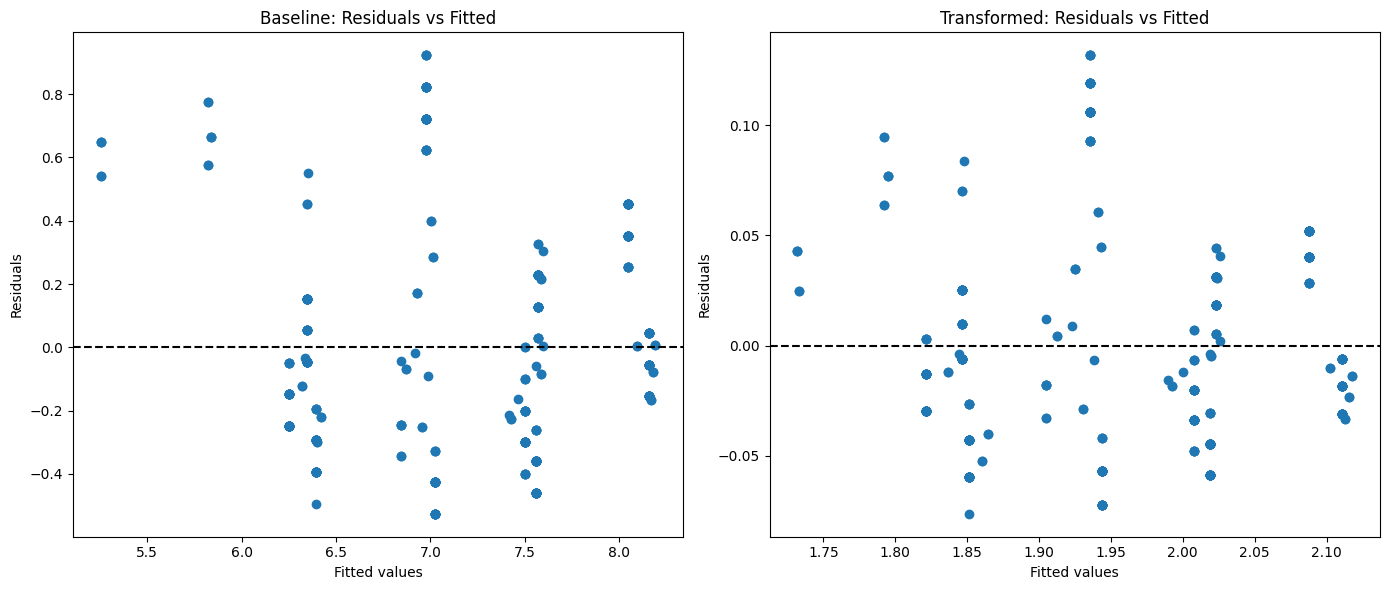

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# baseline
ax0 = axes[0]
ax0.scatter(model_baseline.fittedvalues, model_baseline.resid)
ax0.axhline(y = 0, color = 'k', linestyle = '--')
ax0.set_xlabel("Fitted values")
ax0.set_ylabel("Residuals")
ax0.set_title("Baseline: Residuals vs Fitted")

# transformed
ax1 = axes[1]
ax1.scatter(model_trans.fittedvalues, model_trans.resid)
ax1.axhline(y = 0, color = 'k', linestyle = '--')
ax1.set_xlabel("Fitted values")
ax1.set_ylabel("Residuals")
ax1.set_title("Transformed: Residuals vs Fitted")

plt.tight_layout()
plt.show()

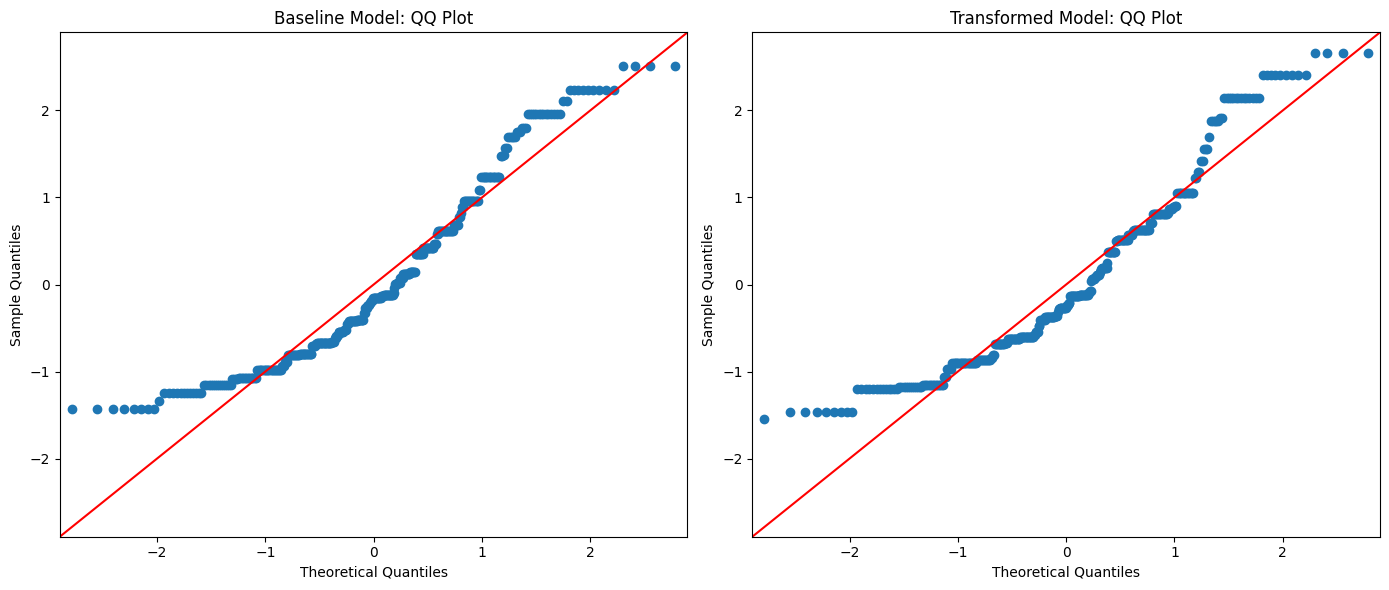

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# baseline
ax0 = axes[0]
sm.qqplot(model_baseline.resid, line='45', fit=True, ax=ax0)
ax0.set_title("Baseline Model: QQ Plot")

# transformed
ax1 = axes[1]
sm.qqplot(model_trans.resid, line='45', fit=True, ax=ax1)
ax1.set_title("Transformed Model: QQ Plot")

plt.tight_layout()
plt.show()

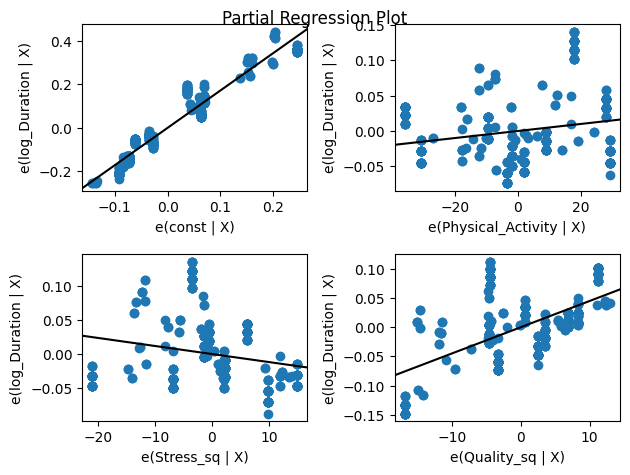

In [11]:
fig = sm.graphics.plot_partregress_grid(model_trans)
plt.show()

#### **5. Discussion & Analysis**

As